# 2021 Intro. to Machine Learning
## Program Assignment #5 - Artificial Neural Networks
### 0816153 陳琮方

In [ ]:
!pip install wandb
!pip install -q -U tensorflow-addons
import wandb
from wandb.keras import WandbCallback

wandb.login()
wandb.init(project="2021-ml-hw5", entity="ctfang")

## Data Input

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = './train.json'
data = pd.read_json(data_path)

print(f'Data size = {data.shape}')

Data size = (29774, 3)


In [ ]:
data.head()

,id,cuisine,ingredients
0,42302,southern_us,"[egg whites, pecans, agave nectar, ground cinn..."
1,43202,greek,"[large egg whites, whole milk, bread crumb fre..."
2,31619,cajun_creole,"[sugar, vegetable oil, yeast, eggs, evaporated..."
3,30920,korean,"[honey, rice vinegar, brown sugar, ginger, gar..."
4,46567,italian,"[mushroom caps, asiago, large shrimp, fat free..."


## Data Visualization
- Plot the data distribution by value count of their labels (targets).
- Plot the data distribution by value count of top 30 features.
- Plot the data distribution by value count of the number of ingredients.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Number of unique labels = 20


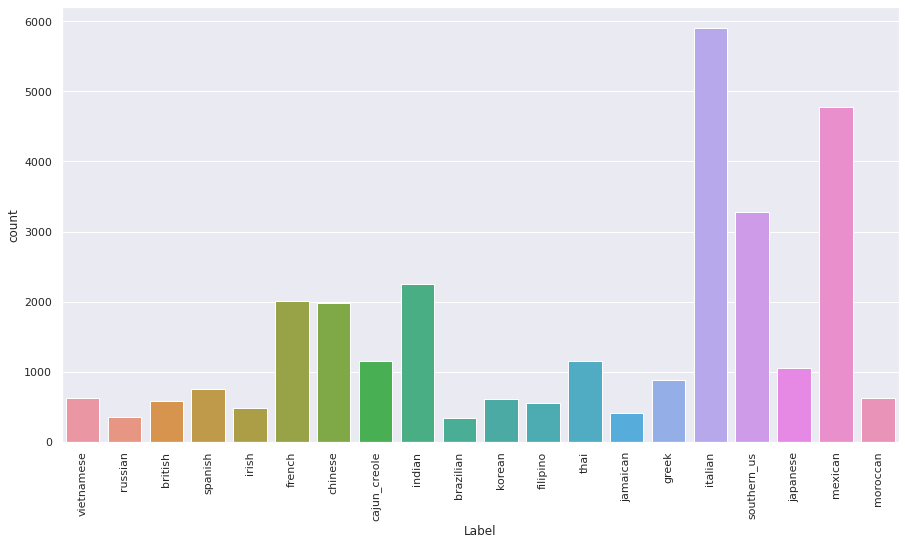

In [ ]:
all_labels = data['cuisine'].tolist()
uni_labels = list(set(all_labels))
print(f'Number of unique labels = {len(uni_labels)}')

now_df = pd.DataFrame({
    'Label' : uni_labels,
    'count' : [all_labels.count(i) for i in uni_labels]
})

sns.set(rc = {'figure.figsize' : (15,8)})
ax = sns.barplot(x = 'Label', y = 'count', data = now_df)
__ = ax.set_xticklabels(uni_labels, rotation = 90)

del all_labels

Number of unique ingredients: 6213


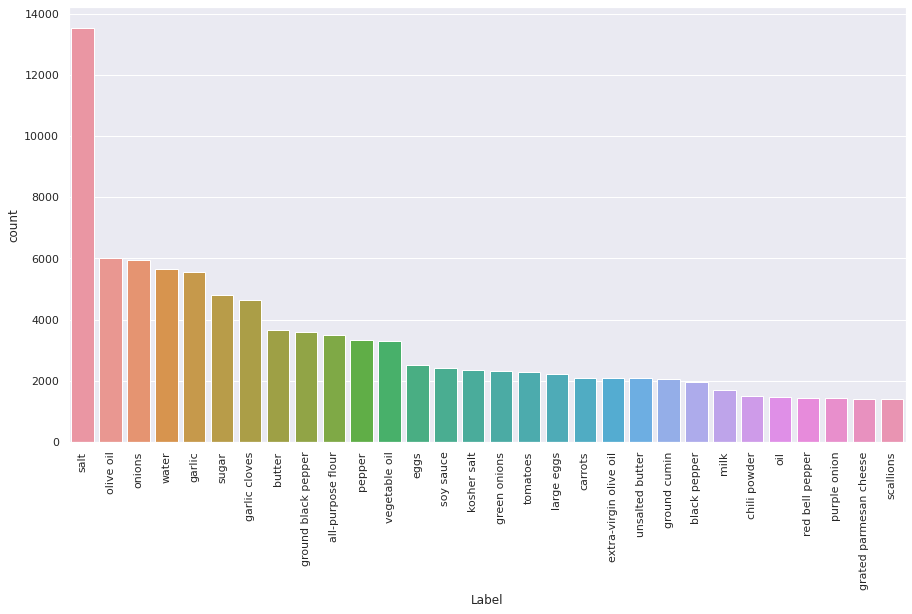

In [ ]:
all_ingreds = []
set_ingreds = []

for i in data['ingredients'].tolist():
    all_ingreds += i

set_ingreds = list(set(all_ingreds))
print(f'Number of unique ingredients: {len(set_ingreds)}')

now_df = pd.DataFrame({
    'Label' : set_ingreds,
    'count' : [all_ingreds.count(i) for i in set_ingreds]
})

now_df = now_df.sort_values(by = ['count'], ascending = [False])
now_df = now_df.head(n = 30)

sns.set(rc = {'figure.figsize' : (15,8)})
ax = sns.barplot(x = 'Label', y = 'count', data = now_df)
__ = ax.set_xticklabels(now_df['Label'].tolist(), rotation = 90)

Number of unique value count of the number of ingredients: 42


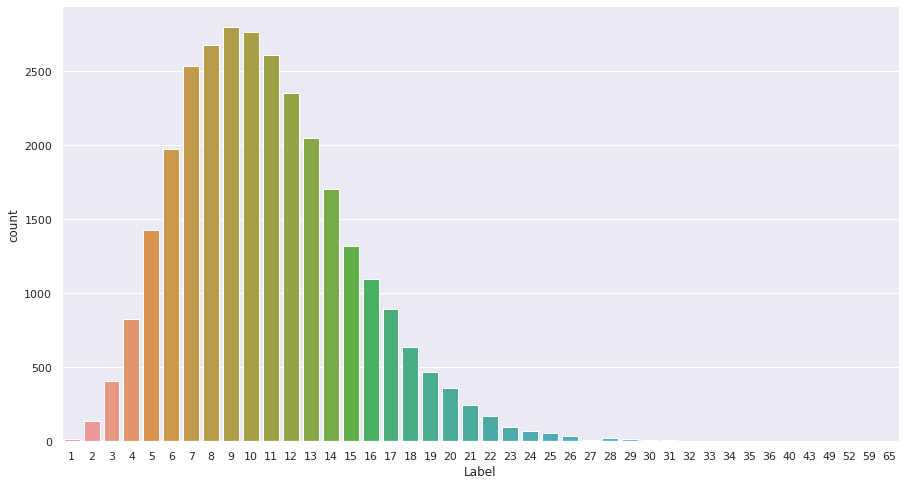

In [ ]:
all_numIng = []
set_numIng = []

for i in data['ingredients'].tolist():
    all_numIng.append(len(i))

set_numIng = list(set(all_numIng))
print(f'Number of unique value count of the number of ingredients: {len(set_numIng)}')

now_df = pd.DataFrame({
    'Label' : set_numIng,
    'count' : [all_numIng.count(i) for i in set_numIng]
})

sns.set(rc = {'figure.figsize' : (15,8)})
ax = sns.barplot(x = 'Label', y = 'count', data = now_df)

del all_numIng
del set_numIng

## Data Preprocessing

我選擇將 data 做 one-hot encoded，未來如果出現未看過的元素就忽略，不會進入影響 model 的預測。
因為元素我覺得並沒有順序性，所以使用 wordtovec 不會比較好，所以我採用 one-hot encoded.

In [ ]:
def dataProcess(ings):
    now = []
    for i in set_ingreds:
        if i in ings:
            now.append(1)
        else:
            now.append(0)
    return now

In [ ]:
num_to_lab = {}
lab_to_num = {}
cnt = 0

for i in uni_labels:
    num_to_lab[cnt] = i
    lab_to_num[  i] = cnt
    cnt += 1

In [ ]:
from sklearn.utils import shuffle

data = shuffle(data)

X_raw_data = data.drop(['cuisine'], axis = 1)
Y_raw_data = data['cuisine'].tolist()

X_data = []
for i in X_raw_data['ingredients'].tolist():
    X_data.append(dataProcess(i))

Y_data = []
for i in Y_raw_data:
    tmp = []
    for j in range(len(uni_labels)):
        tmp.append(0)
    tmp[lab_to_num[i]] = 1
    Y_data.append(tmp)

X_data = np.array(X_data)
Y_data = np.array(Y_data)

In [ ]:
print(f'X_data shape = {X_data.shape}')
print(f'Y_data shape = {Y_data.shape}')

num_feature = X_data.shape[1]

X_data shape = (29774, 6213)
Y_data shape = (29774, 20)


Holdold Validate:
我使用 train_test_split 將資料集分成 7 : 3

In [ ]:
from sklearn.model_selection import train_test_split

seed = 13
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=seed)

print(f'Training size = {X_train.shape[0]}')
print(f'Testing  size = { X_test.shape[0]}')

## Artificial Neural Networks

我使用 Tensorflow 的 keras 建我的模型，使用多層的 linear layer (Dense layer)，中間穿插dropout 來避免 overfit ，以及 BatchNormalization ，最後搭配 soft-max 做輸出判斷。

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
model = keras.Sequential()

model.add(layers.Dense(num_feature, activation="gelu", input_shape=(num_feature, )))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2048, activation="gelu"))
model.add(layers.BatchNormalization(axis=1))
model.add(layers.Dense(1024, activation="gelu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation="gelu"))
model.add(layers.BatchNormalization(axis=1))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="gelu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(20, activation="softmax")) # last layer must use soft-max

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6213)              38607582  
                                                                 
 dropout (Dropout)           (None, 6213)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              12726272  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                      

In [ ]:
BATCH_SIZE = 64
EPOCH = 50

wandb.config = {
    "epochs": EPOCH,
    "batch_size": BATCH_SIZE
}

# Compile model
model.compile(loss='categorical_crossentropy', optimizer= tfa.optimizers.LazyAdam(0.001), 
              metrics=['categorical_accuracy'])

# Fit the model
model.fit(X_train, y_train, validation_data = (X_test, y_test), 
          epochs = EPOCH, batch_size = BATCH_SIZE, 
          callbacks=[WandbCallback()])

## Validation Method

這裡使用 sklearn 的套件，將模型的結果做判斷，印出 Confusion Matrix, Accuracy, Recall, and Precision. (這裡都使用 average = 'marco')

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

def getResult(y_test, y_pred):
    ret = {}
    
    y_test = np.argmax(y_test, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)

    ret['Accuracy'] = np.round(round(accuracy_score(y_test, y_pred), 4) * 100, 2)
    ret['Recall'] = np.round(recall_score(y_test, y_pred, average='macro'), 2)
    ret['Precision'] = np.round(precision_score(y_test, y_pred, average='macro'), 2)
    ret['Confusion Matrix'] = confusion_matrix(y_test, y_pred)

    # print("Accuracy =", ret['Accuracy'])
    # print("Recall =\n", ret['Recall'])
    # print("Precision =\n", ret['Precision'])
    np.set_printoptions(suppress = True)
    print("Confusion Matrix =\n", ret['Confusion Matrix'])

    return ret

In [ ]:
y_pred = model.predict(X_test)

result = {}
result['Result'] = getResult(y_test, y_pred)

df = pd.DataFrame.from_dict(result, orient = 'index')
df

Confusion Matrix =
 [[  71    0    0    0    0    1    9    0    1    0    3   11   24    2
     0    1    0    4    2    0]
 [   0   31    3    5    4    9    0    2    3    0    1    0    0    0
     1   12    4    0    1    0]
 [   1    2   51    1   11   15    0    3    9    0    0    2    0    4
     0    9   17    0    1    0]
 [   0    0    4   75    0   15    1    5    3    1    0    1    0    1
     5   33    6    0   22    3]
 [   0    1    7    1   41   13    0    1    2    1    0    0    0    3
     1   10   17    0    0    0]
 [   0    5    6    5    8  240    1   18    5    0    0    0    0    1
     3   70   28    1    2    1]
 [   7    0    1    0    0    0  304    1    7    0   15    8    6    1
     0   11    7   16    4    0]
 [   0    0    3    0    0    6    1  176    4    1    0    2    0    0
     0   12   30    0    4    0]
 [   0    0    0    2    0    3    2    0  418    0    1    0    4    3
     1    3    4    1    2   10]
 [   0    1    0    3    1    0    

,Accuracy,Recall,Precision,Confusion Matrix
Result,75.28,0.65,0.69,"[[71, 0, 0, 0, 0, 1, 9, 0, 1, 0, 3, 11, 24, 2,..."


## Results

預測 test set，並丟上 kaggle

In [ ]:
test_data_path = './test.json'
test_data = pd.read_json(test_data_path)

print(f'Data size = {test_data.shape}')

test_data.head()

Data size = (10000, 2)


,id,ingredients
0,14,"[olive oil, balsamic vinegar, toasted pine nut..."
1,22,"[canola, jalapeno chilies, salsa, onions, cide..."
2,24,"[large eggs, vanilla extract, firmly packed li..."
3,37,"[queso fresco, margarine, chicken breasts, ext..."
4,40,"[active dry yeast, white sugar, warm water, sa..."


In [ ]:
from tqdm.notebook import tqdm

Y_pred_id = []
Y_pred_ct = []

for index, row in tqdm(test_data.iterrows(), total = test_data.shape[0]):
    now = np.array([dataProcess(row['ingredients'])])
    predict_x = model.predict(now) 
    classes_x = np.argmax(predict_x, axis = 1)
    Y_pred_id.append(row['id'])
    Y_pred_ct.append(num_to_lab[classes_x[0]])

result = pd.DataFrame({'id' : Y_pred_id, 'Category' : Y_pred_ct })

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
from google.colab import files

result.to_csv('answer.csv', index = False)
files.download('answer.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Comparison & Conclusion

這是試了很多種建 model 的方法，也有用過 optimizer, 但準確度都卡在 75% 上下，且我把這個月 colab 的 GPU 上限用完了qq，所以最後作業可能就只能這樣的準確度了。

這次的作業多了競爭的感覺，會一直想要 train 的更好，但是有礙於時間以及 colab ，所以只好就此收手。但是經過這次，有比較清楚模型的建法，以及 kaggle 這個好用的平台，推！

## Kaggle Submission

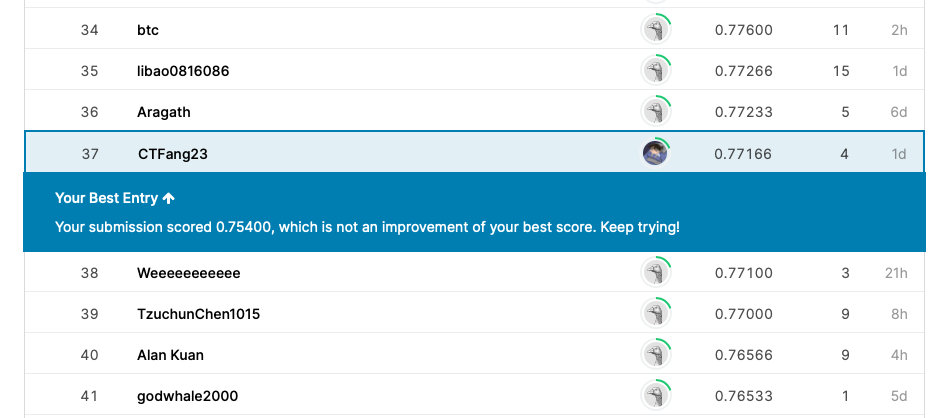

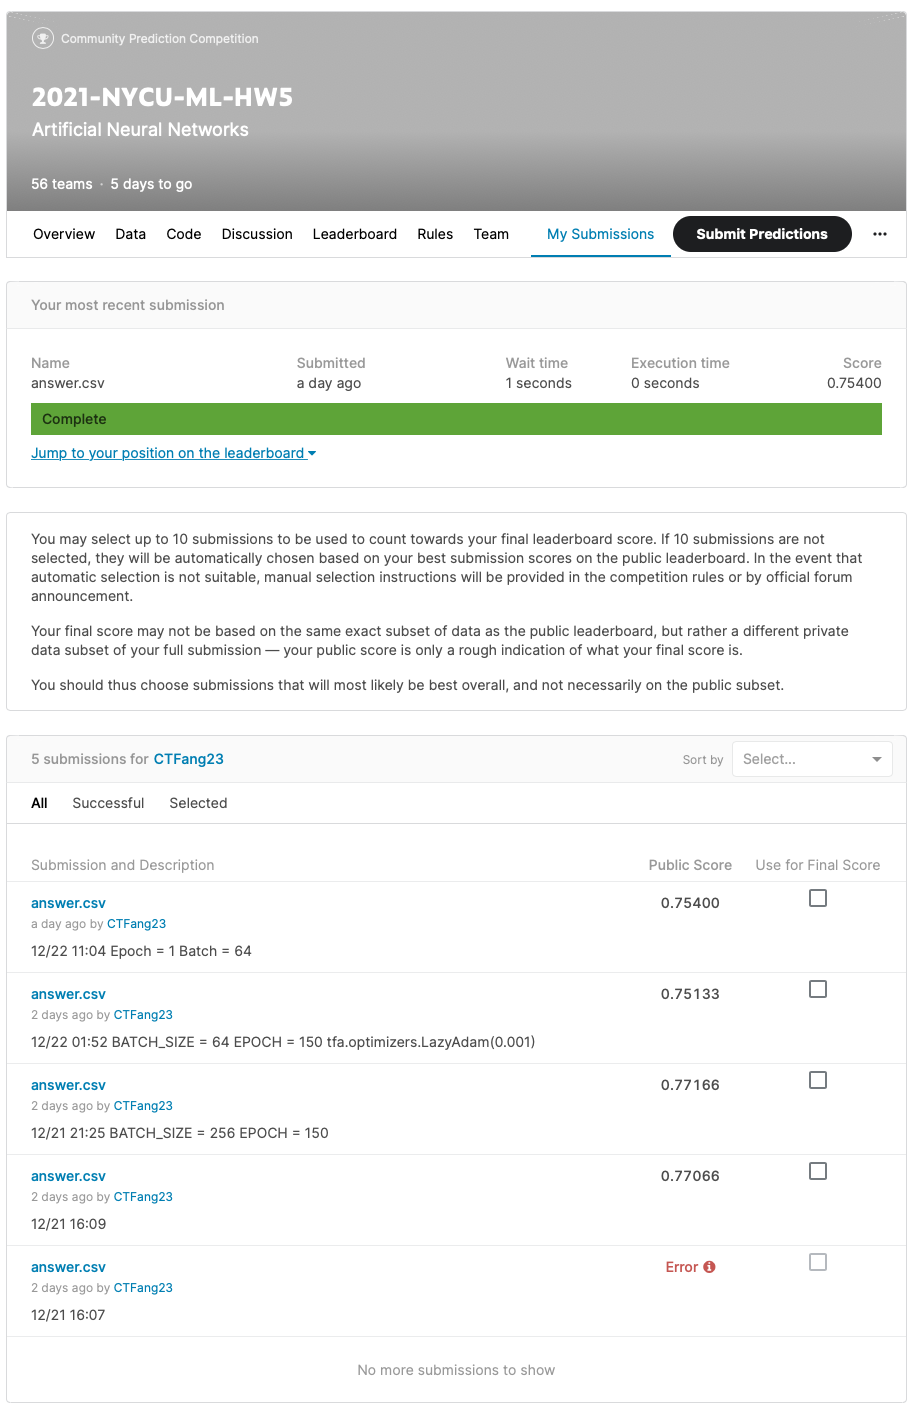